# CNN-Based Image Classification using PyTorch

This notebook implements a **Convolutional Neural Network (CNN)** for Mask Detection.  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

import os
import warnings
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)

### Loading and Visualizing the Dataset
- The dataset consists of labeled images stored in subdirectories, and the model classifies images into two categories:  
With Mask and Without Mask.
- The dataset path is specified, and class labels are extracted.
- The number of images per class is displayed.
- A function `showimages()` is defined to visualize sample images from each class.

In [3]:
path = "../../dataset"

In [4]:
class_labels = sorted(os.listdir(path))
class_labels

['with_mask', 'without_mask']

In [5]:
image_counts = {label: len(os.listdir(os.path.join(path, label))) for label in class_labels}
df = pd.DataFrame(list(image_counts.items()), columns=["Class", "Number of Images"])
print(df)

          Class  Number of Images
0     with_mask              2165
1  without_mask              1930


In [6]:
def showimages(dataset_path, class_labels, samples):
    fig, axes = plt.subplots(len(class_labels), samples, figsize=(samples * 3, len(class_labels) * 3))

    for i, label in enumerate(class_labels):
        class_path = os.path.join(dataset_path, label)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, min(samples, len(image_files)))

        for j, img_file in enumerate(random_images):
            img_path = os.path.join(class_path, img_file)
            image = Image.open(img_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(f"{label}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

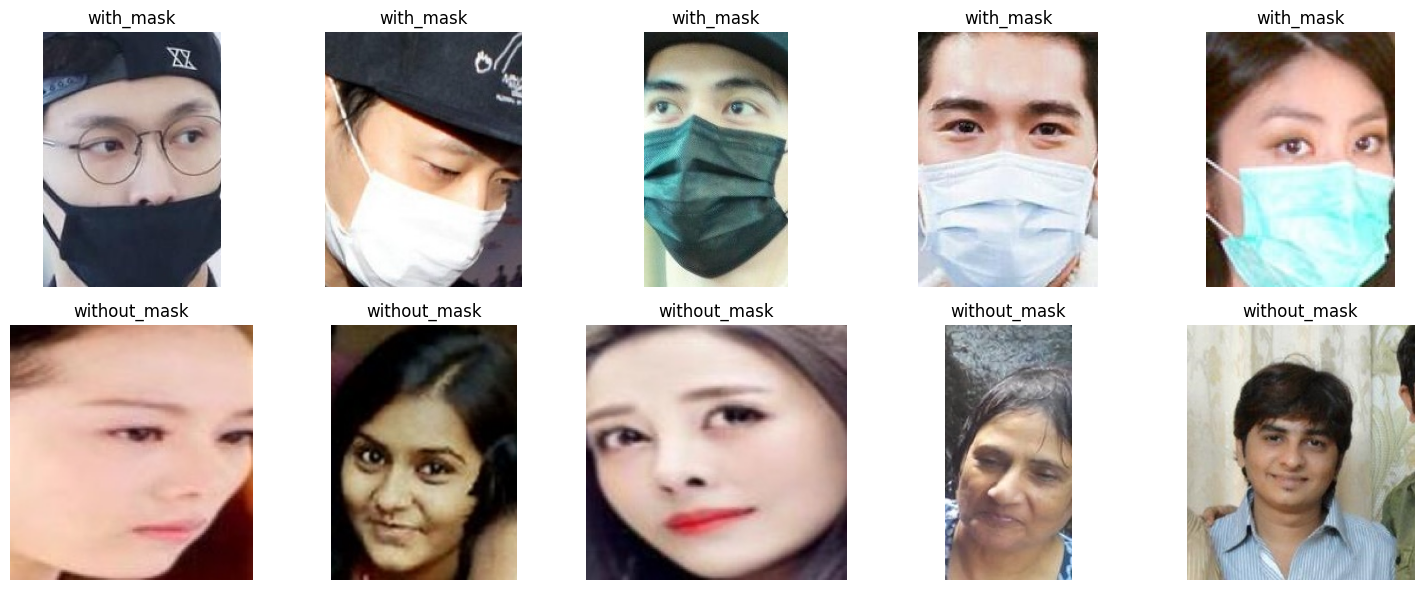

In [7]:
showimages(path, class_labels, samples=5)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cpu')

- The dataset is loaded using `torchvision.datasets.ImageFolder`.
- Images are resized to 32x32 pixels and converted to tensors.
- Data is split into 80% training and 20% testing.

In [10]:
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Defining the Convolutional Neural Network (CNN)
- The CNN has two convolutional layers , two max-pooling layers and two fully connect Layers.
- The final layer uses a sigmoid activation function for binary classification.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

### Training the Model
- The Binary Cross Entropy (BCELoss) is used as the loss function.
- The Adam optimizer is used with a learning rate of 0.001.
- The model is trained for 15 epochs.


In [12]:
model_1 = CNN().to(device)

loss_fun = nn.BCELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [13]:
print(model_1)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [14]:
def train(model, loss_fun, optimizer, epochs, suppress=False):
    loss_list = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            loss = loss_fun(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))

        if suppress == False:
            print(f"Epoch: {epoch+1:<2} | Train Loss: {running_loss/len(train_loader):<10.5f}")
    return loss_list

In [15]:
loss_list_1 = train(model_1, loss_fun, optimizer, epochs=15)

Epoch: 1  | Train Loss: 0.49768   
Epoch: 2  | Train Loss: 0.28832   
Epoch: 3  | Train Loss: 0.24126   
Epoch: 4  | Train Loss: 0.20209   
Epoch: 5  | Train Loss: 0.19256   
Epoch: 6  | Train Loss: 0.15997   
Epoch: 7  | Train Loss: 0.14257   
Epoch: 8  | Train Loss: 0.12698   
Epoch: 9  | Train Loss: 0.11578   
Epoch: 10 | Train Loss: 0.10098   
Epoch: 11 | Train Loss: 0.08440   
Epoch: 12 | Train Loss: 0.08050   
Epoch: 13 | Train Loss: 0.06951   
Epoch: 14 | Train Loss: 0.05980   
Epoch: 15 | Train Loss: 0.05703   


### Evaluating the Model Performance
- Accuracy, F1-score, and AUC are used as evaluation metrics.
- A confusion matrix is printed to analyze model performance.

In [16]:
def accuracy(model, loader, device):
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.inference_mode():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            predictions = torch.round(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    return round(accuracy_score(y_true, y_pred) * 100, 2), y_true, y_pred

In [17]:
def plot_loss(loss_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-', color='b', label="Train Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

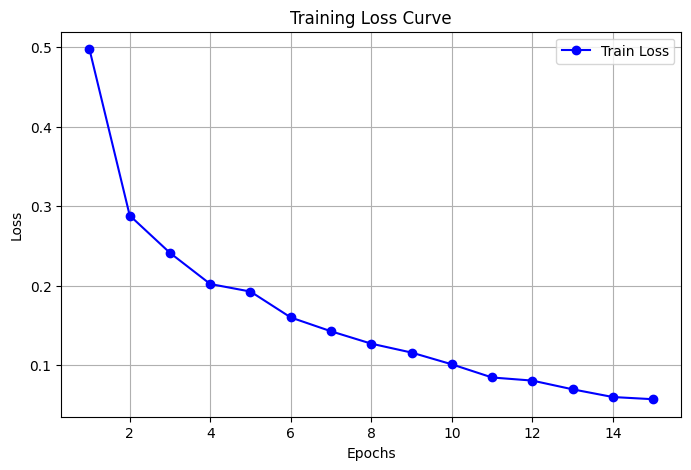

In [18]:
plot_loss(loss_list_1)

In [19]:
def printMetrics(model,train_loader,test_loader, device):
    test_accuracy, y_true, y_pred  = accuracy(model,test_loader,device)
    train_accuracy, _, _ = accuracy(model,train_loader,device)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Train Accuracy : {train_accuracy}%")
    print(f"Test Accuracy : {test_accuracy}% | AUC : {auc:.4f} | F1-Score : {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    dict1 = {
        'learning_rate': 0.001,
        'epochs': 15,
        'optimizer': 'adam',
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'auc': auc,
        'f1_score': f1,
        'confusion Matrix': cm,
        'final_loss': loss_list_1
    }

    return dict1

In [20]:
dict_1 = printMetrics(model_1, train_loader, test_loader, device)

Train Accuracy : 97.62%
Test Accuracy : 95.24% | AUC : 0.9537 | F1-Score : 0.9513
Confusion Matrix:
[[399  31]
 [  8 381]]


In [23]:
def predict_random_images(model, test_dataset, num_images=5):
    model.eval()
    num_images = min(num_images, len(test_dataset))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        idx = random.randint(0, len(test_dataset) - 1)
        transformed_image, true_label = test_dataset[idx]
        original_image_path = test_dataset.dataset.samples[test_dataset.indices[idx]][0]
        original_image = Image.open(original_image_path)
        image_tensor = transformed_image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor).squeeze().item()
        predicted_label = 'Without Mask' if output > 0.5 else 'With Mask'
        true_text_label = 'Without Mask' if true_label == 1 else 'With Mask'
        axes[i].imshow(original_image)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_text_label}\nPred: {predicted_label}", fontsize=12)

    plt.tight_layout()
    plt.show()

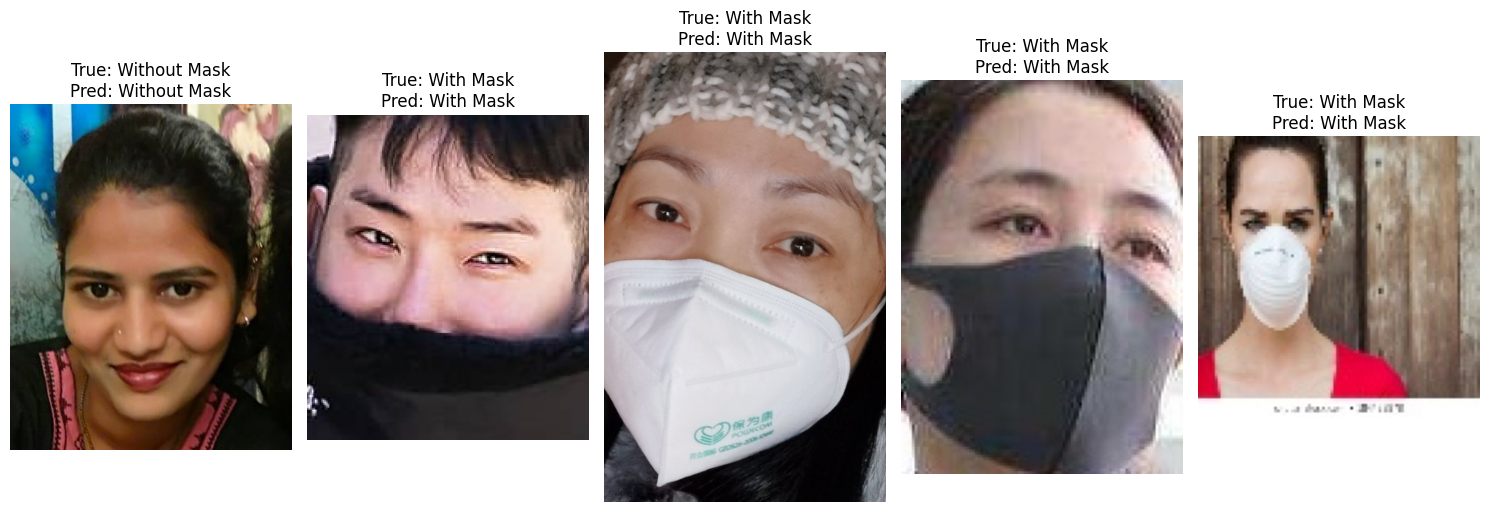

In [24]:
predict_random_images(model_1, test_dataset, num_images=5)

### Trying With Different Hyperparametres
- Experiments are conducted with different learning rates, epochs, and optimizers (`Adam` and `SGD`).
- The results are compared to find the best-performing configuration.

In [25]:
def experiment(hyperparameters_list, train_loader, test_loader, device):
    results = []
    models = []
    
    for lr, epochs, optimizer_type in hyperparameters_list:
        model = CNN().to(device)
        loss_fun = nn.BCELoss()
        
        if optimizer_type.lower() == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_type.lower() == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        print(f"\n\n--- Experiment: LR={lr}, Epochs={epochs}, Optimizer={optimizer_type} ---\n")
        loss_list = train(model, loss_fun, optimizer, epochs=epochs)
        
        test_accuracy, y_true, y_pred  = accuracy(model,test_loader,device)
        train_accuracy, _, _ = accuracy(model,train_loader,device)
        auc = roc_auc_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        
        experiment_result = {
            'learning_rate': lr,
            'epochs': epochs,
            'optimizer': optimizer_type,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'auc': auc,
            'f1_score': f1,
            'confusion Matrix': cm,
            'final_loss': loss_list
        }

        models.append(model)
        results.append(experiment_result)
    
    return results, models

In [26]:
hyperparameters_list = [[0.001, 20, 'adam'],[0.001, 10, 'adam'],[0.001, 17, 'adam'],[0.002, 15, 'adam'],[0.01, 15, 'adam'], [0.01, 20, 'sgd'],[0.02, 20, 'sgd']]

In [27]:
experiment_results, models_list = experiment(hyperparameters_list, 
                                train_loader, 
                                test_loader, 
                                device
                            )



--- Experiment: LR=0.001, Epochs=20, Optimizer=adam ---

Epoch: 1  | Train Loss: 0.42878   
Epoch: 2  | Train Loss: 0.27299   
Epoch: 3  | Train Loss: 0.23493   
Epoch: 4  | Train Loss: 0.20163   
Epoch: 5  | Train Loss: 0.17215   
Epoch: 6  | Train Loss: 0.14792   
Epoch: 7  | Train Loss: 0.12217   
Epoch: 8  | Train Loss: 0.12262   
Epoch: 9  | Train Loss: 0.11010   
Epoch: 10 | Train Loss: 0.09382   
Epoch: 11 | Train Loss: 0.08279   
Epoch: 12 | Train Loss: 0.06753   
Epoch: 13 | Train Loss: 0.05864   
Epoch: 14 | Train Loss: 0.06063   
Epoch: 15 | Train Loss: 0.05121   
Epoch: 16 | Train Loss: 0.03548   
Epoch: 17 | Train Loss: 0.03573   
Epoch: 18 | Train Loss: 0.03531   
Epoch: 19 | Train Loss: 0.03461   
Epoch: 20 | Train Loss: 0.02706   


--- Experiment: LR=0.001, Epochs=10, Optimizer=adam ---

Epoch: 1  | Train Loss: 0.43233   
Epoch: 2  | Train Loss: 0.27804   
Epoch: 3  | Train Loss: 0.22373   
Epoch: 4  | Train Loss: 0.20141   
Epoch: 5  | Train Loss: 0.16637   
Epoch: 

In [28]:
experiment_results.insert(0,dict_1)

In [29]:
def display_results(experiment_results):
    for idx, result in enumerate(experiment_results, 1):
        print(f"\n{'='*50}")
        print(f"EXPERIMENT {idx} RESULTS")
        print(f"{'='*50}")
        
        print(f"Learning Rate    : {result['learning_rate']}")
        print(f"Epochs           : {result['epochs']}")
        print(f"Optimizer        : {result['optimizer']}")
        
        print(f"\nPerformance Metrics:")
        print(f"Train Accuracy   : {result['train_accuracy']:.2f}%")
        print(f"Test Accuracy    : {result['test_accuracy']:.2f}%")
        print(f"AUC Score        : {result['auc']:.4f}")
        print(f"F1 Score         : {result['f1_score']:.4f}")
        
        print("\nConfusion Matrix:")
        print(result['confusion Matrix'])
        
        print(f"\n{'='*50}\n")

In [30]:
display_results(experiment_results)


EXPERIMENT 1 RESULTS
Learning Rate    : 0.001
Epochs           : 15
Optimizer        : adam

Performance Metrics:
Train Accuracy   : 97.62%
Test Accuracy    : 95.24%
AUC Score        : 0.9537
F1 Score         : 0.9513

Confusion Matrix:
[[399  31]
 [  8 381]]



EXPERIMENT 2 RESULTS
Learning Rate    : 0.001
Epochs           : 20
Optimizer        : adam

Performance Metrics:
Train Accuracy   : 99.63%
Test Accuracy    : 95.85%
AUC Score        : 0.9583
F1 Score         : 0.9562

Confusion Matrix:
[[414  16]
 [ 18 371]]



EXPERIMENT 3 RESULTS
Learning Rate    : 0.001
Epochs           : 10
Optimizer        : adam

Performance Metrics:
Train Accuracy   : 97.62%
Test Accuracy    : 95.85%
AUC Score        : 0.9583
F1 Score         : 0.9562

Confusion Matrix:
[[414  16]
 [ 18 371]]



EXPERIMENT 4 RESULTS
Learning Rate    : 0.001
Epochs           : 17
Optimizer        : adam

Performance Metrics:
Train Accuracy   : 99.33%
Test Accuracy    : 95.12%
AUC Score        : 0.9514
F1 Score         :

Loss curves for models with different hyperparametres are plotted.

In [31]:
def plot_losses(experiment_results):
    
    for idx, result in enumerate(experiment_results[:], 0):
        plt.figure(figsize=(8, 5))
        loss_list = result['final_loss']
        plt.plot(
            range(1, len(loss_list) + 1), 
            loss_list, 
            marker='o', 
            linestyle='-', 
            color='b', 
            label=f"Exp {idx}: {result['optimizer']} (LR={result['learning_rate']}) (epochs={result['epochs']})"
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training Loss Curve - Experiment {idx+1}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

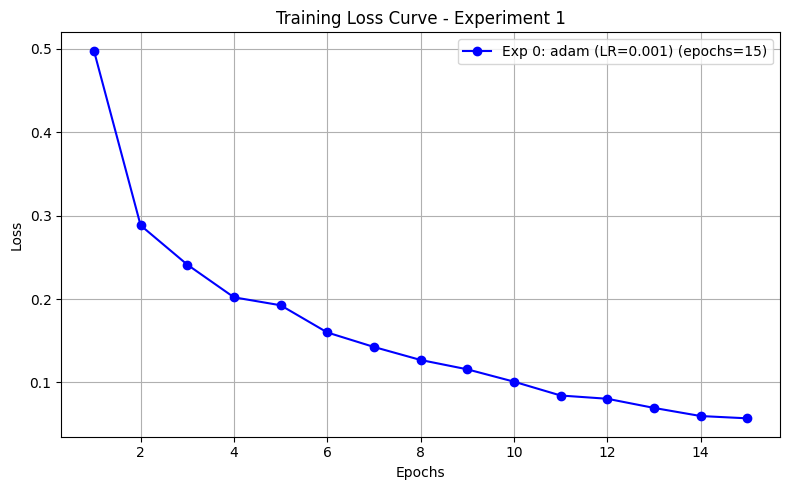

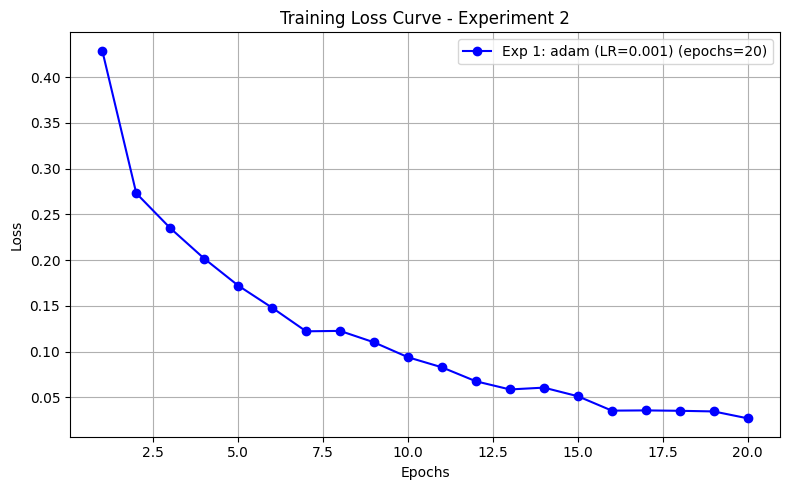

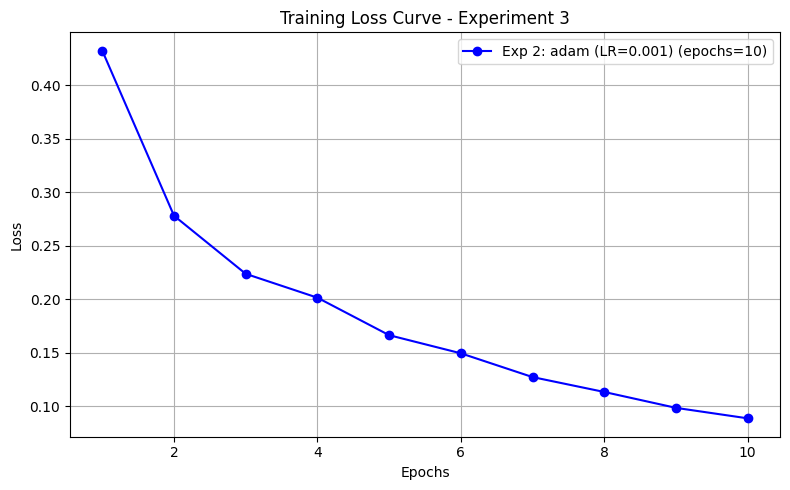

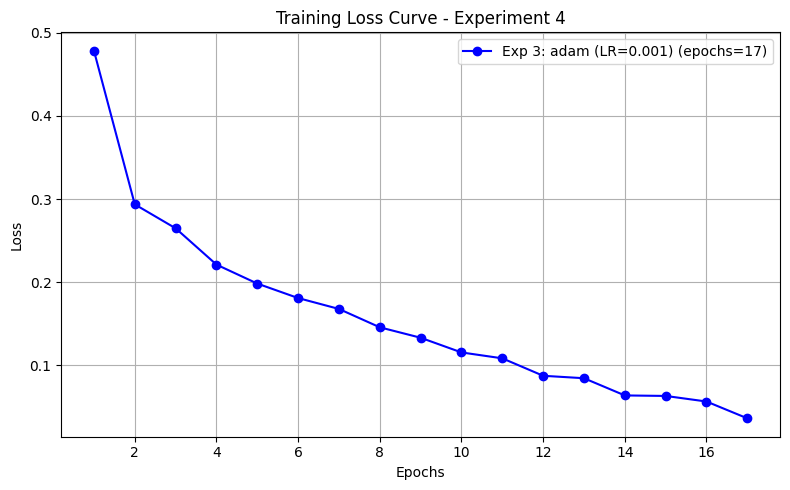

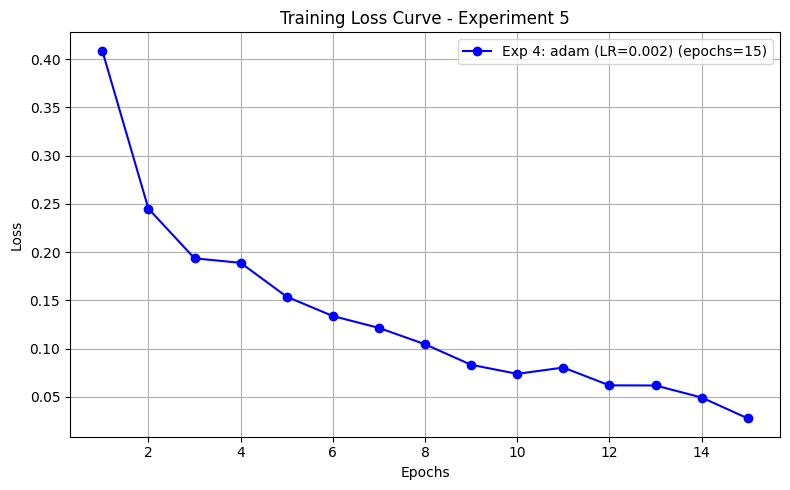

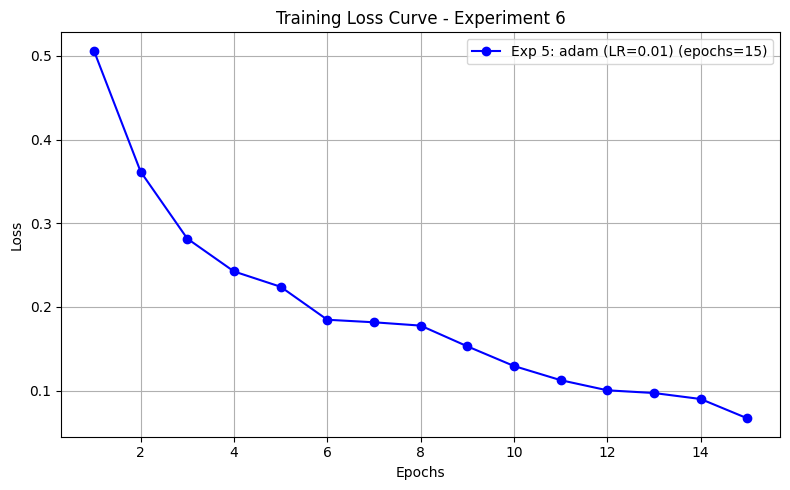

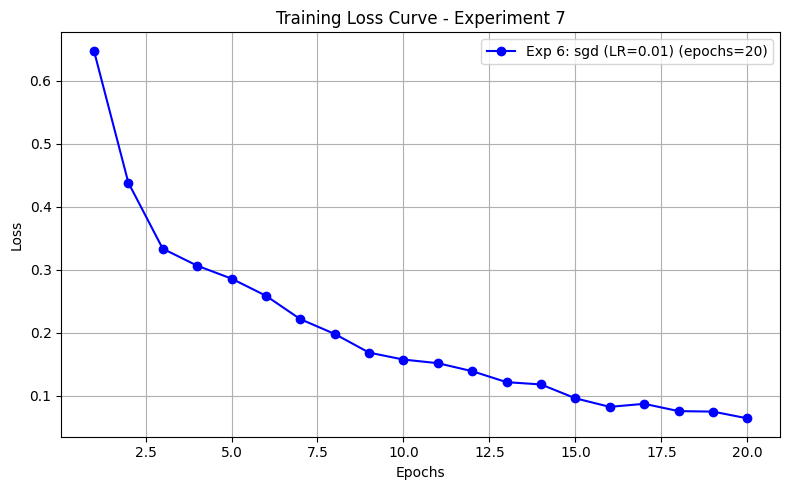

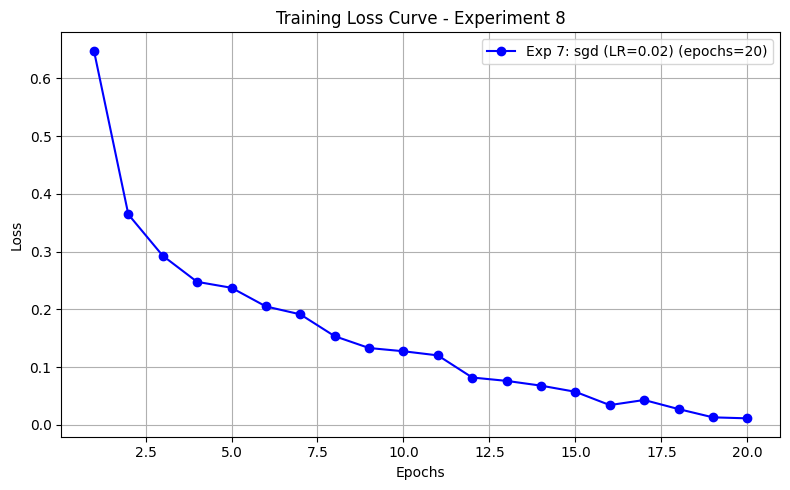

In [32]:
plot_losses(experiment_results)

Representing Results in Tabular Form

In [33]:
from tabulate import tabulate

headers = [key for key in experiment_results[0].keys() if key != "final_loss"]
table_data = [[d[key] for key in headers] for d in experiment_results]

In [41]:
print(tabulate(table_data, headers=headers, tablefmt="grid"))
print("Test and Train Accuracy is in %")

+-----------------+----------+-------------+------------------+-----------------+----------+------------+--------------------+
|   learning_rate |   epochs | optimizer   |   train_accuracy |   test_accuracy |      auc |   f1_score | confusion Matrix   |
+=================+==========+=============+==================+=================+==========+============+====================+
|           0.001 |       15 | adam        |            97.62 |           95.24 | 0.953671 |   0.951311 | [[399  31]         |
|                 |          |             |                  |                 |          |            |  [  8 381]]        |
+-----------------+----------+-------------+------------------+-----------------+----------+------------+--------------------+
|           0.001 |       20 | adam        |            99.63 |           95.85 | 0.958259 |   0.956186 | [[414  16]         |
|                 |          |             |                  |                 |          |            |  [ 18

In [42]:
import numpy as np
model_2 = experiment_results[2]
filtered_model = {k: v for k, v in model_2.items() if k != 'final_loss'}

print("\nThe Model with Highest Test Accuracy:")
print("=" * 50)
for key, value in filtered_model.items():
    if isinstance(value, np.ndarray):
        print(f"{key}:")
        print(value)
    else:
        print(f"{key}: {value}")
print("=" * 50)
print("Test and Train Accuracy is in %")


The Model with Highest Test Accuracy:
learning_rate: 0.001
epochs: 10
optimizer: adam
train_accuracy: 97.62
test_accuracy: 95.85
auc: 0.9582591020505768
f1_score: 0.9561855670103093
confusion Matrix:
[[414  16]
 [ 18 371]]
Test and Train Accuracy is in %


In [46]:
print("The highest test accuracy for SVM is 86.41%, whereas for CNN, it is 95.85%.")
print("The highest F1-Score for SVM is 0.86 , whereas for CNN, it is 0.9561.")
print("The Comparision is done for same SVM and CNN Model in the above both statements.")

The highest test accuracy for SVM is 86.41%, whereas for CNN, it is 95.85%.
The highest F1-Score for SVM is 0.86 , whereas for CNN, it is 0.9561.
The Comparision is done for same SVM and CNN Model in the above both statements.
